In [1]:
import numpy as np
import pandas as pd

In [2]:
df_10k = pd.read_csv('./bag_of_words_full.csv')
df_10k.head()

,Unnamed: 0,mention,watch,episode,right,exactly,happen,thing,scene,violence,...,basic,vampire,color,maker,channel,culture,dramatic,intelligent,scott,sentiment_target
0,0,1,3,2,2,1,1,1,1,4,...,0,0,0,0,0,0,0,0,0,positive
1,1,0,0,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,positive
2,2,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,positive
3,3,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,negative
4,4,0,1,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,positive


In [3]:
df_10k.describe()

,Unnamed: 0,mention,watch,episode,right,exactly,happen,thing,scene,violence,...,search,basic,vampire,color,maker,channel,culture,dramatic,intelligent,scott
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,...,50000.000000,50000.000000,50000.000000,50000.000000,50000.00000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000
mean,24999.500000,0.060760,0.554300,0.098740,0.137980,0.039280,0.141620,0.329960,0.428340,0.042420,...,0.021700,0.020540,0.028900,0.023460,0.02544,0.02366,0.022180,0.025200,0.020640,0.021640
std,14433.901067,0.274426,0.910773,0.563877,0.422167,0.210945,0.441234,0.699611,0.923299,0.255933,...,0.161461,0.154527,0.358423,0.186414,0.18120,0.18028,0.184198,0.173913,0.154449,0.236501
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000
25%,12499.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000
50%,24999.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000
75%,37499.250000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000
max,49999.000000,8.000000,12.000000,21.000000,9.000000,4.000000,9.000000,19.000000,15.000000,7.000000,...,4.000000,4.000000,17.000000,8.000000,7.00000,6.00000,6.000000,5.000000,4.000000,12.000000


<AxesSubplot:>

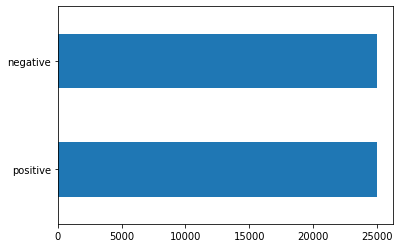

In [4]:
df_10k.sentiment_target.value_counts().plot(kind = 'barh')

In [7]:
n = 5000
df_positive = df_10k[df_10k['sentiment_target'] == 'positive'].sample(n=n)
df_negative = df_10k[df_10k['sentiment_target'] == 'negative'].sample(n=n)

df_sample_test = df_positive.append(df_negative)
df_sample_test.describe()

,Unnamed: 0,mention,watch,episode,right,exactly,happen,thing,scene,violence,...,search,basic,vampire,color,maker,channel,culture,dramatic,intelligent,scott
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,...,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.00000,10000.000000
mean,24934.696000,0.059000,0.554500,0.104600,0.135000,0.040000,0.139200,0.330300,0.435400,0.043000,...,0.020500,0.022700,0.029800,0.023400,0.025000,0.02640,0.020500,0.024500,0.02210,0.025100
std,14452.415478,0.269678,0.901616,0.578526,0.404464,0.209772,0.451491,0.703883,0.945577,0.247704,...,0.151928,0.156803,0.369223,0.176226,0.171982,0.19315,0.174593,0.172345,0.15879,0.281918
min,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000
25%,12377.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000
50%,24928.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000
75%,37470.500000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000
max,49997.000000,7.000000,11.000000,11.000000,6.000000,3.000000,9.000000,12.000000,14.000000,6.000000,...,3.000000,2.000000,12.000000,5.000000,4.000000,5.00000,5.000000,4.000000,3.00000,11.000000


<AxesSubplot:>

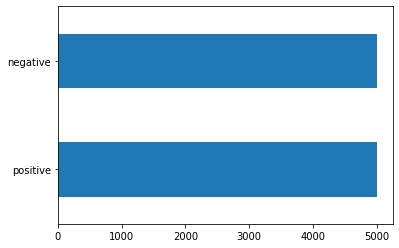

In [8]:
df_sample_test.sentiment_target.value_counts().plot(kind = 'barh')

In [16]:
df_sample_test.drop('Unnamed: 0', axis=1, inplace=True)

In [18]:
df_sample_test.head()

,mention,watch,episode,right,exactly,happen,thing,scene,violence,set,...,basic,vampire,color,maker,channel,culture,dramatic,intelligent,scott,sentiment_target
9141,0,0,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,positive
32704,0,0,0,1,0,0,2,0,0,0,...,0,0,0,0,0,0,0,0,0,positive
25549,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,positive
427,0,1,0,0,0,1,2,1,0,0,...,0,0,0,0,0,0,0,0,0,positive
29652,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,positive


In [23]:
from sklearn.preprocessing import OrdinalEncoder
oe = OrdinalEncoder()

y = oe.fit_transform(df_sample_test.sentiment_target.values.reshape(-1, 1))
y

array([[1.],
       [1.],
       [1.],
       ...,
       [0.],
       [0.],
       [0.]])

In [24]:
X = df_sample_test.drop('sentiment_target', axis=1)
X

,mention,watch,episode,right,exactly,happen,thing,scene,violence,set,...,search,basic,vampire,color,maker,channel,culture,dramatic,intelligent,scott
9141,0,0,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
32704,0,0,0,1,0,0,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0
25549,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
427,0,1,0,0,0,1,2,1,0,0,...,0,0,0,0,0,0,0,0,0,0
29652,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46262,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
17816,0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
29074,0,1,0,0,0,0,3,0,0,0,...,0,0,0,0,0,0,0,0,0,0
39763,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [30]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

,mention,watch,episode,right,exactly,happen,thing,scene,violence,set,...,search,basic,vampire,color,maker,channel,culture,dramatic,intelligent,scott
1519,0,0,0,0,0,0,0,0,0,2,...,0,0,0,0,0,0,0,0,0,0
11326,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
5852,0,2,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20817,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
36667,0,1,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12232,0,0,2,1,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
7841,0,0,0,0,0,1,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0
21096,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
270,0,0,0,0,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0
